## Firstly, training Endotypist<sup>XMBD</sup>

Users can refer to [here](https://doi.org/10.6084/m9.figshare.24126342.v2) giving the description about how to prepare input data required by Endotypist<sup>XMBD</sup> with R. For users who play with Python, [here](./prepare_endotypist_input_tutorial.ipynb) is an example for the preparation of input data with Python.

We re-used the dataset provided by the NeurIPS 2021 challenge, which are available at NCBI GEO with accession number [GSE194122](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE194122).

In this examples, seven replicated datasets from one person were randomly assigned labels as either case or control. It is used to validate whether sample-level labeling has an impact on the outcomes of Endotypist<sup>XMBD</sup>.

These replicated datasets were generated at four different locations.

In [1]:
%%bash

CUDA_VISIBLE_DEVICES=1  python Endotypist.py --sup-data-file /home/zfeng/zfeng/MOdREM_ex/Multiome_NIPS2021_donor1_shuffle/nips2021_BMMC_donor1_rna.txt \
                        --sup-condition-file /home/zfeng/zfeng/MOdREM_ex/Multiome_NIPS2021_donor1_shuffle/nips2021_BMMC_donor1_phenotype.txt \
                        --sup-condition2-file /home/zfeng/zfeng/MOdREM_ex/Multiome_NIPS2021_donor1_shuffle/nips2021_BMMC_donor1_uwv.txt \
                        -lr 0.0001 \
                        -n 300 \
                        -bs 1000 \
                        --seed 0 \
                        --cuda \
                        --layer-dropout-rate 0.1 \
                        -zi exact \
                        -hl 500 \
                        -zd 200 \
                        -likeli negbinomial \
                        --condition-type onehot \
                        --condition2-type onehot \
                        --save-model nips2021_BMMC_donor1_shuffle_tutorial.pth 2>&1 | tee nips2021_BMMC_donor1_shuffle_tutorial.log

1 epoch: avg losses 6514317.3800 0.0000 elapsed 2.8211 seconds
2 epoch: avg losses 4773734.9650 0.0000 elapsed 2.6990 seconds
3 epoch: avg losses 4676248.5237 0.0000 elapsed 2.6508 seconds
4 epoch: avg losses 4589415.5862 0.0000 elapsed 2.7410 seconds
5 epoch: avg losses 4510423.0225 0.0000 elapsed 2.6500 seconds
6 epoch: avg losses 4461103.0700 0.0000 elapsed 2.6546 seconds
7 epoch: avg losses 4415710.0050 0.0000 elapsed 2.6537 seconds
8 epoch: avg losses 4381523.4200 0.0000 elapsed 2.6503 seconds
9 epoch: avg losses 4353021.1562 0.0000 elapsed 2.7485 seconds
10 epoch: avg losses 4329191.6725 0.0000 elapsed 2.6608 seconds
11 epoch: avg losses 4303462.2600 0.0000 elapsed 2.6500 seconds
12 epoch: avg losses 4289676.7675 0.0000 elapsed 2.6599 seconds
13 epoch: avg losses 4258746.4750 0.0000 elapsed 2.6507 seconds
14 epoch: avg losses 4227195.9912 0.0000 elapsed 2.6513 seconds
15 epoch: avg losses 4193378.6488 0.0000 elapsed 2.6737 seconds
16 epoch: avg losses 4170537.7750 0.0000 elapsed 

## Secondly, generating the cell expression after removing unwanted variations

In [19]:
import pandas as pd

from Endotypist import Endotypist
from utils.scdata_cached import SingleCellCached

import torch
from torch.utils.data import DataLoader

from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks

%load_ext rpy2.ipython


In [3]:

ModelPath = 'nips2021_BMMC_donor1_shuffle_tutorial.pth'
Omic1Path='/home/zfeng/zfeng/MOdREM_ex/Multiome_NIPS2021_donor1_shuffle/nips2021_BMMC_donor1_rna.txt'
LabelPath=None
ConditionPath=None
ConditionPath2=None


In [4]:
# load model
model = torch.load(ModelPath)

batch_size = 10000

use_float64 = False
use_cuda = True

In [5]:
# load data
data_cached = SingleCellCached(Omic1Path, LabelPath, ConditionPath, ConditionPath2, 'tutorial', use_cuda=False, use_float64 = use_float64)
data_loader = DataLoader(data_cached, batch_size = batch_size, shuffle = False)

In [6]:
# predict denoised expression
exprs = []


# use the appropriate data loader
for xs1,ys,ks,ks2 in data_loader:
    if use_cuda:
        xs1 = xs1.cuda()

    expr = model.generate_scaled_expression(xs1, mute_condition=False, mute_condition2=True, mute_noise=False)
    
    if use_cuda:
        expr = expr.cpu().detach().numpy()
    else:
        expr = expr.detach().numpy()

    exprs.append(expr)


exprs = np.concatenate(exprs, axis=0)



In [7]:
cells = pd.read_csv('/home/zfeng/zfeng/MOdREM_ex/Multiome_NIPS2021_donor1_shuffle/nips2021_BMMC_donor1_cell.txt', header=None)
genes = pd.read_csv('/home/zfeng/zfeng/MOdREM_ex/Multiome_NIPS2021_donor1_shuffle/nips2021_BMMC_donor1_gene.txt', header=None)

In [43]:
df = pd.DataFrame(exprs, index=cells.iloc[:,0].values)
meta = pd.read_csv('/home/zfeng/zfeng/MOdREM_ex/Multiome_NIPS2021_donor1_shuffle/nips2021_BMMC_donor1_metadata.csv',index_col=0)

## Thirdly, plotting results with R

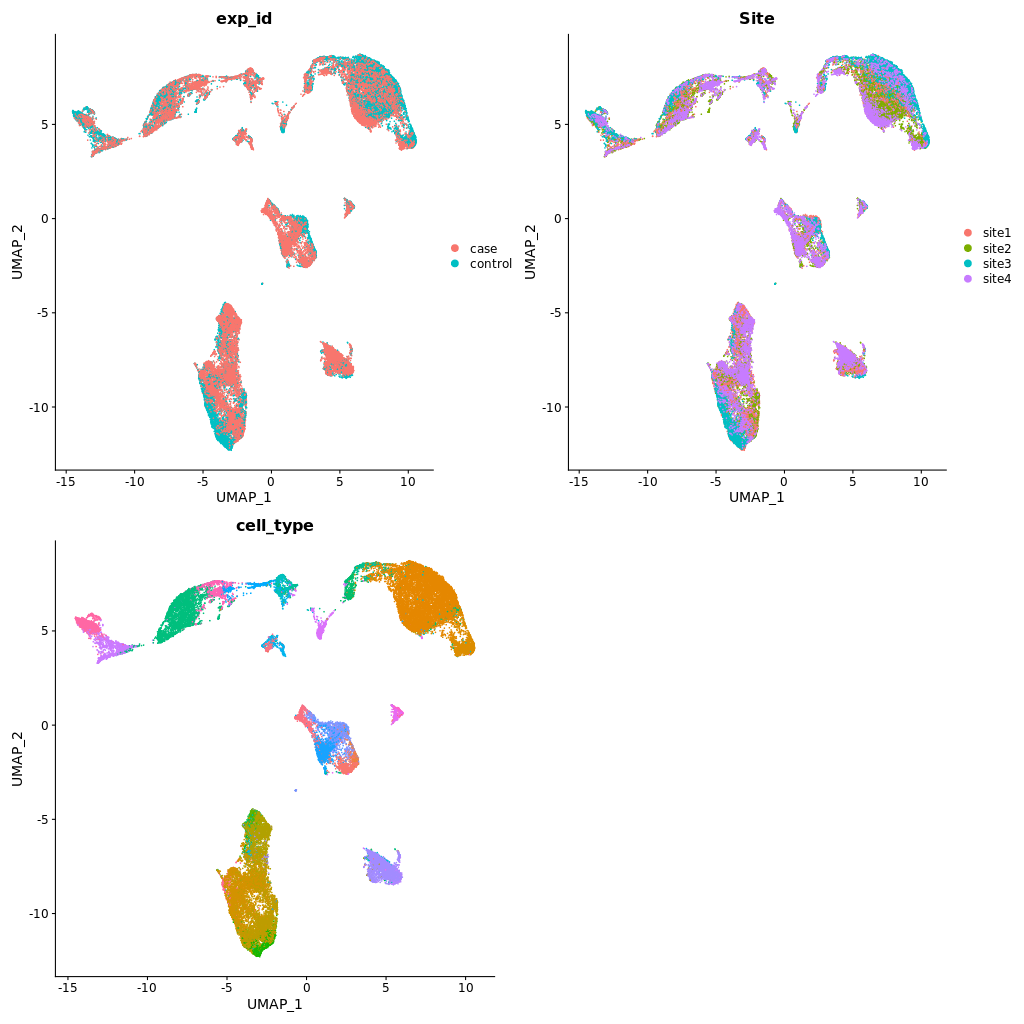

In [44]:
%%R -i df,meta -w 1024 -h 1024 -u px

library(Seurat)
library(dplyr)
library(data.table)
library(uwot)
library(patchwork)

data <- df
embed <- umap(data, n_threads = 40, pca=20)
colnames(embed) <- c('UMAP_1','UMAP_2')


recon <- CreateSeuratObject(data[,1:10] %>% t, meta.data = meta[rownames(data),])
recon[['umap']] <- CreateDimReducObject(embed %>% as.matrix(), key = 'UMAP_')


(DimPlot(recon, reduction = 'umap', group.by = 'exp_id') + DimPlot(recon, reduction = 'umap', group.by = 'Site')) /
(DimPlot(recon, reduction = 'umap', group.by = 'cell_type') +NoLegend() + plot_spacer())
